# Import Packages

In [1]:
#!pip install seaborn livelossplot pytorchsummary torchmetrics

%matplotlib inline

import os
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.style.use('ggplot')
from livelossplot import PlotLosses

from tensorflow import keras

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary as summary_
# import torchvision as tv
# from torchvision.transforms import ToTensor
import torchmetrics as tm

def set_random_seed_torch(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42    
set_random_seed_torch(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2022-07-31 12:16:37.069757: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# 1. Load dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# training_data = tv.datasets.MNIST(root='data', download=True, train=True, transform=ToTensor())
# test_data     = tv.datasets.MNIST(root='data', download=True, train=False, transform=ToTensor())

# 2. Preprocessing

In [3]:
x_train, x_test = x_train / 255, x_test / 255
x_train = x_train[:, None, :, :].astype('float32')  # (B, H, W) -> (B, C, H, W)
x_test  = x_test[:, None, :, :].astype('float32')

In [4]:
INPUT_SHAPE  = x_train[0].shape
OUTPUT_SHAPE = 1
N_CLASSES    = len(np.unique(y_train))

print("- Training(X, y):", x_train.shape, y_train.shape)
print("- Test(X, y):", x_test.shape, y_test.shape)
print("- Number of classes:", N_CLASSES)

- Training(X, y): (60000, 1, 28, 28) (60000,)
- Test(X, y): (10000, 1, 28, 28) (10000,)
- Number of classes: 10


In [5]:
def generate_dataloader_torch(X, y=None, batch_size=32, shuffle=True):
    """Generate TensorFlow dataset from array-like data (X, y)

    Parameters
    ----------
    X : array-like
        Input data

    y : numpy.ndarray (default=None)
        Output data

    batch_size : int (default=32)
        Batch size

    shuffle : bool (default=True)
        Whether to shuffle data

    Returns
    -------
    PyTorch dataloader : torch.utils.data.DataLoader
        Generated dataloader
    """
    from torch.utils.data import Dataset, DataLoader
    
    class CustomDataset(Dataset):
        def __init__(self, X, y=None):
            self.X = torch.tensor(X, device=device)
            if y is None:
                y = torch.zeros(len(self.X), device=device)  # dummy
            self.y = torch.tensor(y, device=device, dtype=torch.long)
        def __len__(self):
            return len(self.X)
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    # 1. Generate dataset
    X = np.array(X, dtype=np.float32)
    if y is not None:
        y = np.array(y, dtype=np.float32)
        ds = CustomDataset(X, y)
    else:
        ds = CustomDataset(X)

    # 2. Generate dataloader
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_dl = generate_dataloader_torch(x_train, y_train)
test_dl  = generate_dataloader_torch(x_test, y_test)

# 3. Modeling

In [6]:
FILTERS = 32
KERNEL_SIZE = 3
UNITS   = 128


class MyModel(nn.Module):
    def __init__(self, filters, kernel_size, units, n_classes, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.conv1 = nn.LazyConv2d(filters, kernel_size)
        self.d1 = nn.LazyLinear(units)
        self.output = nn.LazyLinear(n_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.flatten(start_dim=1)
        x = F.relu(self.d1(x))
        logits = self.output(x)
        return logits
    def summary(self):
        summary_(self, self.input_shape)
        
    
model = MyModel(FILTERS, KERNEL_SIZE, UNITS, N_CLASSES, INPUT_SHAPE).to(device)

criterion = nn.CrossEntropyLoss()
get_acc   = tm.Accuracy(num_classes=N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters())

model.summary()

/opt/conda/envs/tf_torch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Linear-2                  [-1, 128]       2,769,024
            Linear-3                   [-1, 10]           1,290
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 10.57
Estimated Total Size (MB): 10.74
----------------------------------------------------------------


# 4. Training

In [7]:
def train_step(images, labels):
    probs = model(images)
    loss = criterion(probs, labels)
    acc  = get_acc(probs.argmax(1), labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, acc
    
def test_step(images, labels):
    probs = model(images)
    loss = criterion(probs, labels)
    acc  = get_acc(probs.argmax(1), labels)
    return loss, acc

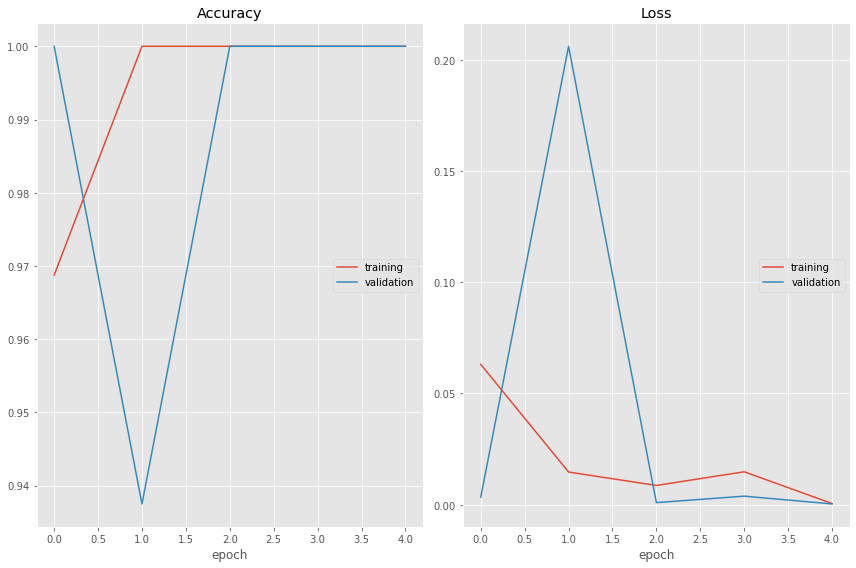

100%|██████████| 5/5 [00:34<00:00,  6.96s/it]

Accuracy
	training         	 (min:    0.969, max:    1.000, cur:    1.000)
	validation       	 (min:    0.938, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.001, max:    0.063, cur:    0.001)
	validation       	 (min:    0.000, max:    0.206, cur:    0.000)


In [8]:
EPOCHS = 5
liveloss = PlotLosses()

rst = pd.DataFrame(columns=['loss', 'acc', 'val_loss', 'val_acc'], index=pd.Index([], name='Epoch'))
for epoch in tqdm(range(1, EPOCHS+1)):
    for images, labels in train_dl:
        loss, acc = train_step(images, labels)

    with torch.no_grad():
        for test_images, test_labels in test_dl:
            val_loss, val_acc = test_step(test_images, test_labels)
    
    rst.loc[epoch] = list(map(float, [loss, acc, val_loss, val_acc]))
    liveloss.update(rst.loc[epoch])
    liveloss.send()